<a href="https://colab.research.google.com/github/ahzaidy/Programs/blob/main/CPSC_5410_HW1_P4_BO_LCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

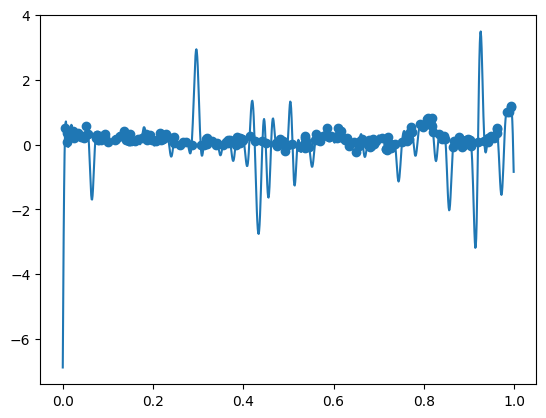

>x=0.434, f()=-2.758, actual=0.025
>x=0.917, f()=-2.622, actual=0.122
>x=0.855, f()=-1.827, actual=0.149
>x=0.000, f()=-6.442, actual=0.415
>x=0.061, f()=-1.204, actual=0.297
>x=0.746, f()=-1.039, actual=0.128
>x=0.553, f()=-0.689, actual=0.013
>x=0.520, f()=-1.820, actual=-0.014
>x=0.513, f()=-0.993, actual=0.103
>x=0.969, f()=-0.391, actual=0.553
>x=0.410, f()=-0.292, actual=0.240
>x=0.784, f()=-0.519, actual=0.464
>x=0.241, f()=-0.372, actual=0.153
>x=0.309, f()=-0.404, actual=0.085
>x=0.294, f()=-3.897, actual=0.242
>x=0.299, f()=-1.134, actual=0.138
>x=0.456, f()=-0.102, actual=0.062
>x=0.671, f()=-0.301, actual=-0.024
>x=0.377, f()=-0.477, actual=0.113
>x=0.289, f()=-0.166, actual=0.067
>x=0.422, f()=-0.601, actual=0.134
>x=0.275, f()=-0.347, actual=0.254
>x=0.495, f()=-0.203, actual=0.021
>x=0.653, f()=-0.226, actual=0.008
>x=0.730, f()=-0.232, actual=0.151
>x=0.740, f()=-0.680, actual=0.006
>x=0.926, f()=-0.199, actual=-0.043
>x=1.000, f()=0.026, actual=1.206
>x=0.911, f()=-0.1

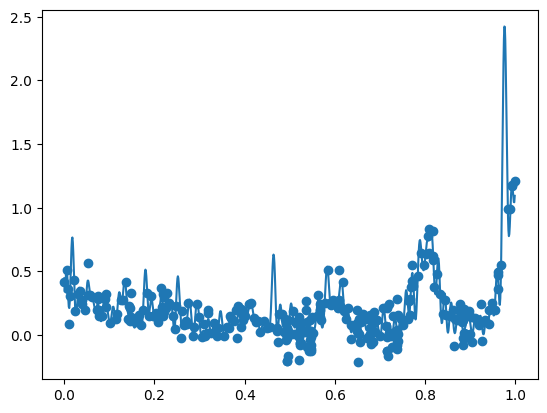

Best Result: x=0.651, y=-0.216


In [9]:
from math import sin, cos, pi
from numpy import arange, vstack, argmin, asarray
from numpy.random import normal, random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from warnings import catch_warnings, simplefilter
from matplotlib import pyplot
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Objective function
def objective(x, noise=0.1):
    noise = normal(loc=0, scale=noise)
    return ((x-0.6) ** 2 + x ** 2 * cos(5 * pi * x) ** 6.0) + noise

# Surrogate function
def surrogate(model, X):
    with catch_warnings():
        simplefilter("ignore")
        return model.predict(X, return_std=True)

# LCB (Lower Confidence Bound) acquisition function
def acquisition(X, Xsamples, model, kappa=1.96):
   # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    mu, std = surrogate(model, Xsamples)
    scores = mu - kappa * std  # Lower confidence bound
    return scores

# Optimize the acquisition function
def opt_acquisition(X, y, model):
    Xsamples = random(100).reshape(-1, 1)
    scores = acquisition(X, Xsamples, model)
    ix = argmin(scores)  # Select the point with the lowest acquisition score
    return Xsamples[ix, 0]

# Plot function
def plot(X, y, model, img_name='plot'):
    pyplot.scatter(X, y)
    Xsamples = asarray(arange(0, 1, 0.001)).reshape(-1, 1)
    ysamples, _ = surrogate(model, Xsamples)
    pyplot.plot(Xsamples, ysamples)
    pyplot.show()
    pyplot.close()

# Sample the domain sparsely with noise
X = random(200).reshape(-1, 1)
y = asarray([objective(x) for x in X]).reshape(-1, 1)

# Define the model
kernel = RBF(length_scale=0.1, length_scale_bounds=(1e-2, 10.0))
model = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, n_restarts_optimizer=2)

# Fit the model using X, y
model.fit(X, y)

# Plot before optimization
plot(X, y, model, img_name='gp_initial_model')

# Perform the optimization process
for i in range(100):
    # Select the next point to sample
    x = opt_acquisition(X, y, model)
    # Sample the point
    actual = objective(x)
    # Summarize the finding
    est, _ = surrogate(model, [[x]])
    print('>x=%.3f, f()=%.3f, actual=%.3f' % (x, est[0], actual))
    # Add the data to the dataset
    X = vstack((X, [[x]]))
    y = vstack((y, [[actual]]))
    # Update the model
    model.fit(X, y)

# Plot final result
plot(X, y, model, img_name='gp_result_model')

# Best result
ix = argmin(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix].item(), y[ix].item()))